In [1]:
%pylab inline
import numpy as np

import networkx as nx
from utility import ER_GNP, make_SBM, uniform_weight_edges
from sis import simulate_SIS, get_p_curve, get_p_curves, make_raster_plots
import importlib
from manage import (
    rank_by_evec,
    decrease_nodes_weights,
    decrease_top_nodes_weights,
    manage_nodes,
)

Populating the interactive namespace from numpy and matplotlib


# 1. Make Network to Study

In [52]:
np.random.seed(111)

In [138]:
def get_community_4(comm_type):
    PI = None
    if comm_type == "line":
        PI = get_community_line(4)
    if comm_type == "star":
        PI = np.array([[.1,.05,.05,.05],
                      [.05,.1,.00,.00],
                      [.05,.00,.1,.00],
                      [.05,.00,.00,.1]])
    if comm_type == "square":
        PI = np.array([[.1,.05,.00,.05],
                      [.05,.1,.05,.00],
                      [.00,.05,.1,.05],
                      [.05,.00,.05,.1]])
    if comm_type == "closed":
        PI = np.array([[.1,.05,.05,.05],
                      [.05,.1,.05,.05],
                      [.05,.05,.1,.05],
                      [.05,.05,.05,.1]])
    return PI

def get_community_line(n):
    main = np.full((n, ), 0.1)
    sub = np.full((n-1, ), 0.05)
    sup = np.full((n-1, ), 0.05)
    return np.diag(main, k=0) + np.diag(sub, k=1) + np.diag(sup, k=-1)
    

    # doh the U and square have the same ecol - different social!
def get_community_2(comm_type):
    PI = None
    if comm_type == "open": # the U
        PI = np.array([[.1,.05],
                      [.05,.1,]])
    if comm_type == "closed": # the square or O
         PI = np.array([[.1,.05],
                      [.05,.1,]])
    return PI


def get_community(comm_type, n=4):
    scaling = 0.5
    if n == 4:
        return scaling * get_community_4(comm_type)
    if n == 2:
        return scaling * get_community_2(comm_type)
    if n > 4:
        if comm_type != "line":
            raise ValueError("comm type must be line for n > 4")
        return scaling * get_community_line(n)
    else:
        return None


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.2890127692807327
0.2710857411326457


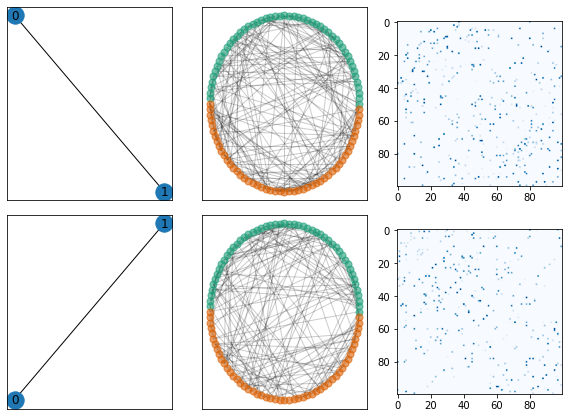

In [139]:
K = 2 # number communities

f1,ax = plt.subplots(2,3,figsize = (8,6))

for i, ct in enumerate(["open", "closed"]):
    PI = get_community(ct, n=K)
    N = 50*K # nodes
    Ns = np.ones(K,dtype=int)*N/K
    A,id_sets = make_SBM(Ns,PI)
    A = uniform_weight_edges(A,.1)
    lam = np.max(np.linalg.eigh(A)[0])
    print(lam)
   
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in range(K)]
    #colors = Pastel1#['b','r','g','y']
    P = nx.to_networkx_graph(PI, create_using=nx.Graph())
    nx.draw_networkx(P, ax=ax[i, 0])
    G = nx.to_networkx_graph(A,create_using=nx.Graph())
    pos = nx.circular_layout(G)
    for t,ids in enumerate(id_sets):
        nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[i, 1],node_size=50,node_color=colors[t],alpha=.6)
    nx.draw_networkx_edges(G,pos,ax=ax[i, 1],edge_size=2,node_color='k',alpha=.2)   

    temp = ax[i, 2].imshow(A,cmap='Blues')

#cbar = plt.colorbar(temp);
plt.tight_layout()
savefig('figs/community_net_plot.pdf')

In [77]:
#importlib.reload(manage)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.33057469169596243


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

0.33473852769126405


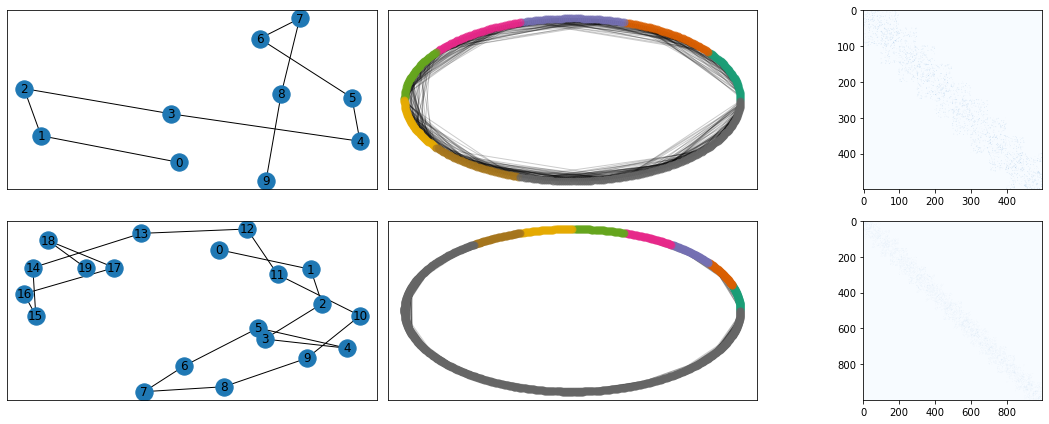

In [140]:
# 2 examples of the line for k >> 2
f1,ax = plt.subplots(2,3,figsize = (16,6))

for i, k in enumerate([10, 20]):
    PI = get_community("line", n=k)
    N = 50 * k # nodes
    Ns = np.ones(k, dtype=int)*N/k
    A,id_sets = make_SBM(Ns,PI)
    A = uniform_weight_edges(A,.1)
    lam = np.max(np.linalg.eigh(A)[0])
    print(lam)
   
    cmap = plt.get_cmap('Dark2')
    colors = [cmap(i) for i in range(k)]
    #colors = Pastel1#['b','r','g','y']
    P = nx.to_networkx_graph(PI, create_using=nx.Graph())
    nx.draw_networkx(P, ax=ax[i, 0])
    G = nx.to_networkx_graph(A,create_using=nx.Graph())
    pos = nx.circular_layout(G)
    for t,ids in enumerate(id_sets):
        nx.draw_networkx_nodes(G,pos,nodelist = ids,ax=ax[i, 1],node_size=50,node_color=colors[t],alpha=.6)
    nx.draw_networkx_edges(G,pos,ax=ax[i, 1],edge_size=2,node_color='k',alpha=.2)   

    temp = ax[i, 2].imshow(A,cmap='Blues')

#cbar = plt.colorbar(temp);
plt.tight_layout()
savefig('figs/community_net_plot.pdf')

# the U / open

In [149]:
def make_A(K, N, comm_type):
    PI = get_community(comm_type, n=K)
    N = N * k # nodes
    Ns = np.ones(K, dtype=int)*N/K
    A,id_sets = make_SBM(Ns,PI)
    A = uniform_weight_edges(A,.5)
    lam = np.max(np.linalg.eigh(A)[0])
    return A, lam


AU, _ = make_A(2, 50, "open")

# budgets and p = managmeent effect
p = 0.7
KK = 64
Ks = np.arange(0,KK,K)

# random mgmt
rank_opts = {'type':'random' # rank completely at random
            }

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(AU))] # global control

A_random,lams_random, Ksr = manage_nodes(AU,rank_opts,manage_opts)

# 
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'evec', # rank according to eigenvector centrality  - no 'info_id_sets' needed
            }
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(AU))] # global control


AA2U,lams2U, Ks2U = manage_nodes(AU,rank_opts,manage_opts)


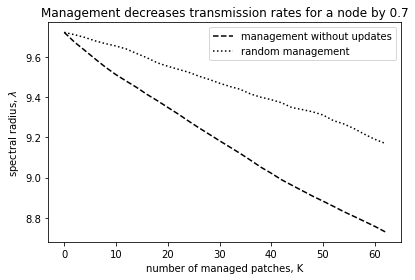

In [150]:
#plot(arange(K),lams[0]*np.ones(K),'k:')
plt.plot(Ks2U,lams2U,'k--')
plt.plot(Ksr,lams_random,'k:')
plt.legend(['management without updates',
            'random management'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));
plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(K)+'.pdf')

In [151]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'distributed':True # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'distributed_evec' # rank according to distributes eigenvector centrality
            }
b = int(ceil(KK / K))
rank_opts['budget'] = np.repeat(b, K)

# independent management
rank_opts['info_id_sets'] = [np.array(i) for i in id_sets]
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]
manage_opts['online'] = False # update ranking after each modification? no
AA4U,lams4U, Ks4U = manage_nodes(AU,rank_opts,manage_opts)


# info sharing -- community minded folks but don't have a connection to their neighbors
rank_opts['info_id_sets'] = [np.array(i) for i in id_sets] 

rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = False # update ranking after each modification? yes
AA6tU,lams6tU, Kst6U = manage_nodes(AU,rank_opts,manage_opts)

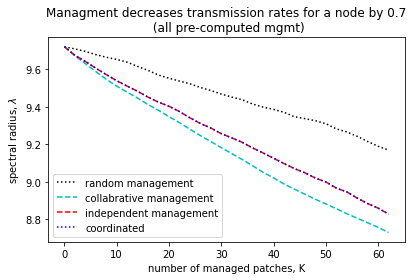

In [153]:
f1,ax = plt.subplots(1,1,figsize=(6,4));



plt.plot(Ksr,lams_random,'k:');

plt.plot(Ks2U,lams2U,'c--')
plt.plot(Ks4U,lams4U,'r--');

plt.plot(Kst6U,lams6tU,'b:');
plt.legend(['random management', 'collabrative management','independent management','coordinated'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Managment decreases transmission rates for a node by '+ str(manage_opts['p']) +'\n (all pre-computed mgmt)');
plt.tight_layout();
plt.savefig('figs/node_management_SBM'+str(K)+'.pdf')

We compare characteristics of independent to coordinated management

# the square / O / closed

In [155]:
AO, _ =  make_A(2, 50, "closed")

p = 0.7
KK = 64
Ks = np.arange(0,KK,K)

# random mgmt
rank_opts = {'type':'random' # rank completely at random
            }

manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(AO))] # global control

A_random,lams_random, Ksr = manage_nodes(AO,rank_opts,manage_opts)

# 
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'online':False, # update ranking after each modification?
               'distributed':False # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K
rank_opts = {'type':'evec', # rank according to eigenvector centrality
            }
rank_opts['budget'] = [KK]
rank_opts['control_id_sets'] = [np.arange(len(AO))] # global control

AA2O,lams2O, Ks2O = manage_nodes(AO,rank_opts,manage_opts)


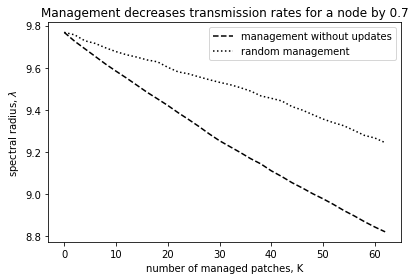

In [156]:
#plot(arange(K),lams[0]*np.ones(K),'k:')
plt.plot(Ks2O,lams2O,'k--')
plt.plot(Ksr,lams_random,'k:')
plt.legend(['management without updates',
            'random management'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Management decreases transmission rates for a node by '+ str(manage_opts['p']));
plt.tight_layout();
plt.savefig('figs/node_management_SBM222'+str(K)+'.pdf')

In [157]:
manage_opts = {'p':p, # decrease the edge weights of selected nodes by p% (p=1 is the strongest management) 
               'distributed':True # compute rankings separately for different subgraphs
              }
manage_opts['budget_step'] = K

rank_opts = {'type':'distributed_evec' # rank according to distributes eigenvector centrality
            }
b = int(ceil(KK / K))
rank_opts['budget'] = np.repeat(b, K)

# independent management
rank_opts['info_id_sets'] = [np.array(i) for i in id_sets]
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]
manage_opts['online'] = False # update ranking after each modification? no
AA4O,lams4O, Ks4O = manage_nodes(A,rank_opts,manage_opts)


# info sharing -- community minded folks that DO have a connection to their neighbors
rank_opts['info_id_sets'] = [np.arange(len(A)) for i in id_sets] # global knowledge (and care)
rank_opts['control_id_sets'] = [np.array(i) for i in id_sets]

manage_opts['online'] = False # update ranking after each modification? yes
AA6tO,lams6tO, Kst6O = manage_nodes(A,rank_opts,manage_opts)

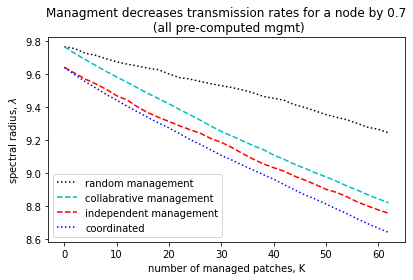

In [159]:
f1,ax = plt.subplots(1,1,figsize=(6,4));



plt.plot(Ksr,lams_random,'k:');

plt.plot(Ks2O,lams2O,'c--')
plt.plot(Ks4O,lams4O,'r--');

plt.plot(Kst6O,lams6tO,'b:');
plt.legend(['random management', 'collabrative management','independent management','coordinated'])

plt.xlabel('number of managed patches, K')
plt.ylabel('spectral radius, $\lambda$')

plt.title('Managment decreases transmission rates for a node by '+ str(manage_opts['p']) +'\n (all pre-computed mgmt)');
plt.tight_layout();
plt.savefig('figs/node_management_SBM'+str(K)+'.pdf')

## differences in networks post-managmenet

We compare characteristics of independent to coordinated management

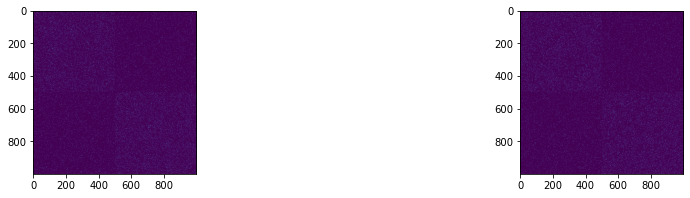

In [160]:
def make_scatters(ax,As):
    for t in range(len(As)):
        im = ax[t].imshow(As[t]);
        #plt.set_colorbar(im);
    return
        

f1,ax = plt.subplots(1,2,figsize=(16,3));
# u vs sq before management -- not visible??
make_scatters(ax,[AU, AO])

## Examine change in distributional impact

we have the patch level probability of occupancy by a new outbreak (near threshold) as 
$p_i \approx \gamma * \lambda / \beta u_i$ with $\mathbf u$ right eigen vector of $A$. 

This gives us a way to look at expected total "damage": $\gamma \lambda /\beta \sum_{i \in Manager} u_i$. We can compare this for globally-knowledgable/concerned manager vs locally-knowledgable/concerned. Note that because this is linear in $\gamma\lambda/\beta$ the _relative_ total damage among managers is given just by the sums of the eigenvalue entries.

In [100]:
def dist_impact(A):
    l, u = np.linalg.eigh(A)
    l_max_idx = np.argmax(l) # should be the last one at position len(l)-1
    u_max = u[:, l_max_idx]
    return [sum(u_max[i]) for i in id_sets] / sum(u_max)

#id_sets

The **distribution of total damage across scenarios** for management strategies:



In [101]:
import pandas as pd  # for formatting


data = [dist_impact(AA6t),
        dist_impact(AA2),
        dist_impact(AA4),
        dist_impact(AA5t),
        dist_impact(AA),
        dist_impact(AA3)
       ]
df = pd.DataFrame(data, columns=["mgr 1", "mgr 2"], 
            index=["non-online", "non-online", "non-online", "online", "online", "online"])
df['strategy'] = [
    "cooperative",
    "collabrative planned",
    "independent",
       "coordinated",
    "collabrative coordinated",
    "independent"
]
df[['strategy', 'mgr 1', 'mgr 2']].round(2)

,strategy,mgr 1,mgr 2
non-online,cooperative,0.0,1.0
non-online,collabrative planned,-0.0,1.0
non-online,independent,1.0,-0.0
online,coordinated,1.0,-0.0
online,collabrative coordinated,1.0,0.0
online,independent,1.0,0.0


The **change in percentage of damage incurred** when changing management strategies:



In [102]:
data = [dist_impact(AA6t)- dist_impact(AA4),
        dist_impact(AA6t)-dist_impact(AA2),
        dist_impact(AA2)-dist_impact(AA4),
        dist_impact(AA5t)-dist_impact(AA3),
        dist_impact(AA5t)-dist_impact(AA),
        dist_impact(AA)-dist_impact(AA3)
       ]

df = pd.DataFrame(data, columns=["mgr 1", "mgr 2"], 
            index=["non-online", "non-online", "non-online", "online", "online", "online"])
df['change in strategy'] = [
    "independent to cooperative",
    "collabrative to cooperative",
    "independent to collabrative",
       "independent to coordinated",
    "top-down to coordinated",
    "independent to collabrative"
]

df[['change in strategy', 'mgr 1', 'mgr 2']].round(2)

,change in strategy,mgr 1,mgr 2
non-online,independent to cooperative,-1.0,1.0
non-online,collabrative to cooperative,0.0,0.0
non-online,independent to collabrative,-1.0,1.0
online,independent to coordinated,-0.0,-0.0
online,top-down to coordinated,-0.0,-0.0
online,independent to collabrative,-0.0,0.0
